In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import tri, cm
import meshio

Definições Geométricas

In [2]:
msh = meshio.read('./mesh/new_cube.msh')

X = msh.points[:,0]
Y = msh.points[:,1]
Z = msh.points[:,2]

In [73]:
dt = 1e-5
Nt = 1_000
T = np.arange(0, Nt*dt, dt)

In [74]:
### Time discretization
# beta = 0.0 : Explicit
# beta = 0.5 : Crank-Nicholson
# beta = 1.0 : Implicit
beta = 0.5

In [57]:
IEN = np.array([])
IENBound = np.array([])

for cellBlock in msh.cells:
    if cellBlock.type == 'triangle':
        if IENBound.shape == (0,):
            IENBound = cellBlock.data
        else:
            IENBound = np.concatenate([IENBound, cellBlock.data])
    elif cellBlock.type == 'tetra':
        if IEN.shape == (0,):
            IEN = cellBlock.data
        else:
            IEN = np.concatenate([IEN, cellBlock.data])

In [58]:
Npoints = len(X)
ne = IEN.shape[0]

In [82]:
v1 = np.array([0, 0, 1])
v2 = np.array([0, 2, 0])

np.cross(v1, v2)

normal_vec = np.cross(v1, v2)
normal_vec = normal_vec/np.linalg.norm(normal_vec)


In [45]:
# IENboundTypeElem = list(msh.cell_data['gmsh:physical'][0] - 1)
# boundNames = list(msh.field_data.keys())
# IENboundElem = [boundNames[elem] for elem in IENboundTypeElem]
# npoints = len(X)
# ne = IEN.shape[0]

In [ ]:
# Boundary conditions
Tcc = lambda x, y, z, t: (x*x + y*y + z*z)*(np.exp(t) - 1)

In [46]:
# # cria lista de nos do contorno
# cc = np.unique(IENbound.reshape(IENbound.size))
# ccName = [[] for i in range( len(X) )]
# for elem in range(0,len(IENbound)):
#  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
#  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
#  ccName[ IENbound[elem][2] ] = IENboundElem[elem]
# # plot malha e pontos de contorno (export para vtk)
# meshio.write_points_cells('malha.vtk',
#  msh.points,
#  msh.cells,)

In [59]:
cc = np.unique(IENBound.reshape(IENBound.size))
meshio.write_points_cells('./mesh/new_cube.vtk',
 msh.points,
 msh.cells,)

Definições do material

In [60]:
# Boundary conditions
Tcc = lambda x, y, z, t: (x*x + y*y + z*z)*(np.exp(t) - 1)

In [61]:
rho = 1
cv = 1
alpha = 1

kappa = [1, 1, 1] # kx, ky, kz

Q = lambda x, y, z, t: ((x*x + y*y + z*z)*np.exp(t) -6*alpha*(np.exp(t) - 1))*rho*cv

In [62]:
#form functions for 2D
def IENfunc3DTet(K, M, IEN):
    for IENelem in IEN:
        tet_matrix = np.array([[1, X[IENelem[i]], Y[IENelem[i]] , Z[IENelem[i]]] for i in range(4)])
        tet_volume = np.linalg.det(tet_matrix)/6

        melem = (tet_volume/20)*np.array(([2, 1, 1, 1],
                                          [1, 2, 1, 1],
                                          [1, 1, 2, 1],
                                          [1, 1, 1, 2]))
        
        [a_list, b_list, c_list, d_list] = np.linalg.inv(tet_matrix)
        
        kxelem = kappa[0]*tet_volume*np.array([[b_list[i]*b_list[j] for i in range(4)] for j in range(4)])
        kyelem = kappa[1]*tet_volume*np.array([[c_list[i]*c_list[j] for i in range(4)] for j in range(4)])
        kzelem = kappa[2]*tet_volume*np.array([[d_list[i]*d_list[j] for i in range(4)] for j in range(4)])

        kelem = kxelem + kyelem + kzelem

        for ilocal in range(4):
            iglobal = IENelem[ilocal]

            for jlocal in range(4):
                jglobal = IENelem[jlocal]

                K[iglobal,jglobal] += kelem[ilocal,jlocal]
                M[iglobal,jglobal] += melem[ilocal,jlocal]

In [63]:
K  = np.zeros((Npoints, Npoints), dtype = float) 
M  = np.zeros((Npoints, Npoints), dtype = float)

IENfunc3DTet(K, M, IEN)

In [64]:
T_vec = np.zeros((Nt, Npoints))

In [65]:
T_vec[0] = [Tcc(X[i], Y[i], Z[i], 0) for i in range(Npoints)]

In [66]:
A1  = M/dt + beta*K
A2 = M/dt - (1 - beta)*K

A1inv = np.linalg.inv(A1)

In [67]:
for i in range(1, Nt):
    Q_vec = np.array([Q(X[j], Y[j], Z[j], T[i]) for j in range(Npoints)])
    b = A2@T_vec[i - 1] + M@Q_vec

    for j in cc:
        b[j] = Tcc(X[j], Y[j], Z[j], T[i])
    
    T_vec[i] = A1inv@b

In [68]:
expected_T = np.array(
        [
            [Tcc(X[i], Y[i], Z[i], T[j]) for i in range(Npoints)
        ] for j in range(Nt)
        ]
    )

In [69]:
error = abs(expected_T - T_vec)

In [70]:
error_MSE = [np.sqrt(sum(elem**2)/Npoints) for elem in error]

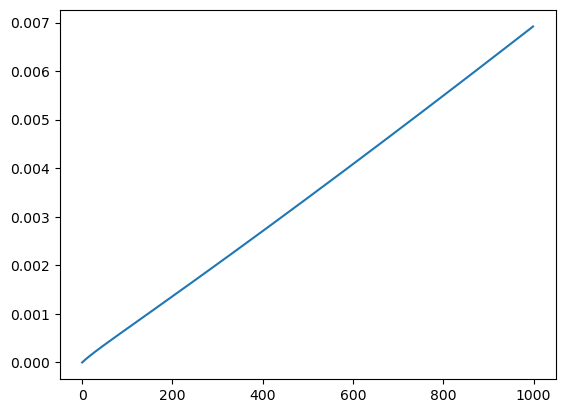

In [71]:
plt.plot(error_MSE)
plt.show()

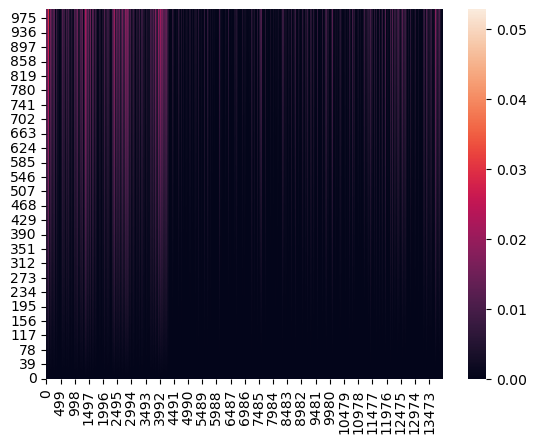

In [72]:
ax = sns.heatmap(error)
ax.invert_yaxis()
plt.show()